# Prediction comparison of RFC and KNC

In [23]:
# Imports
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier


In [2]:
# Import np arrays
X = np.load('../data/processed/pln_X_small_features_raw_128x128.npy')
y = np.load('../data/processed/pln_y_small_labels.npy')

In [3]:
# Data pipeline
# Remove row 41-128 based on feature importance
X_reshape = X.reshape(-1, 128, 128)
X_top40 = X_reshape[:, :40, :]
X_top40_flat = X_top40.reshape(X_top40.shape[0], -1)


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top40_flat, y, test_size=0.20, 
    random_state=42,
    stratify=y
)

In [5]:
# Scaling
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Initializing model
knc = KNeighborsClassifier(metric='minkowski', n_neighbors=2, weights='distance')
rfc = RandomForestClassifier(max_depth= None, min_samples_split=5, n_estimators=150)

In [7]:
# Fitting data
knc.fit(X_trained_scaled, y_train)
rfc.fit(X_trained_scaled, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Adding lower threshold
rfc_y_proba = rfc.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3
rfc_y_pred = (rfc_y_proba >= threshold).astype(int)

knc_y_proba = knc.predict_proba(X_test_scaled)[:, 1]
knc_y_pred = (knc_y_proba >= threshold).astype(int)

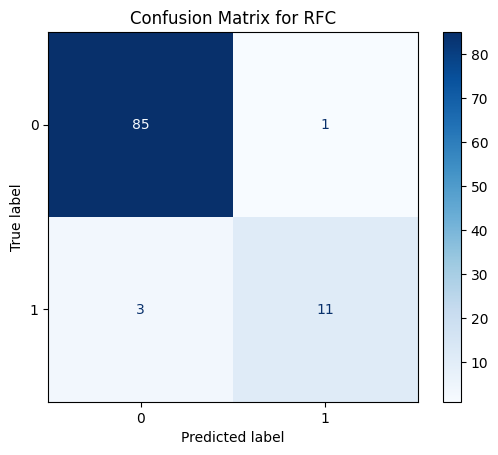

In [11]:
cm = confusion_matrix(y_test, rfc_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for RFC")
plt.show()

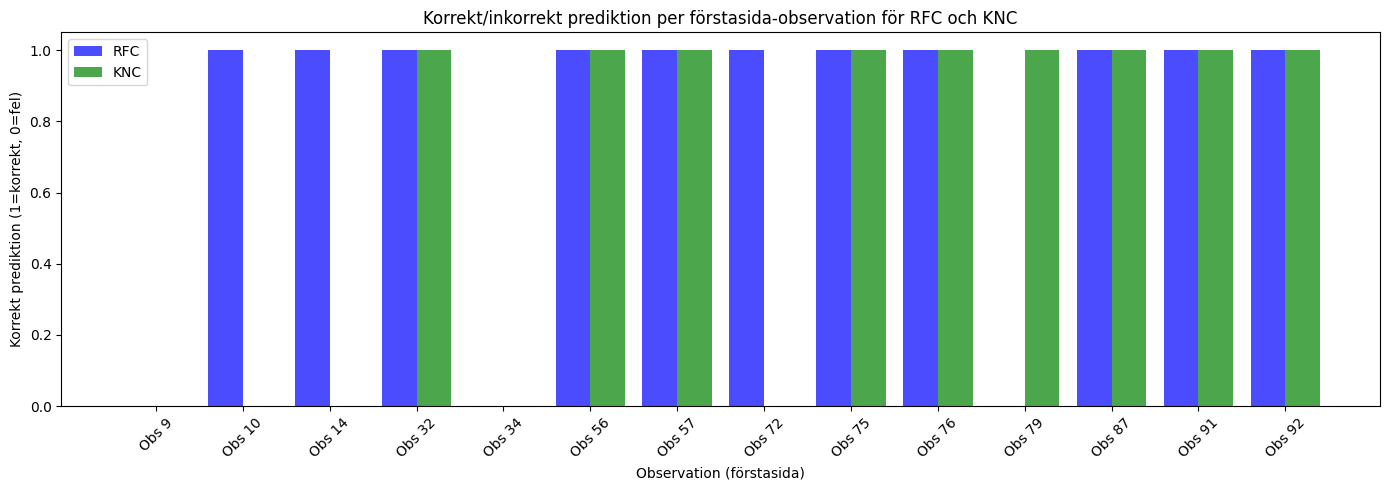

In [22]:
# Mask och index för förstasidor
mask_firstpage = (y_test == 1)
firstpage_idx = np.where(mask_firstpage)[0]  # Index i testdatan för varje förstasida

# Korrekt prediktion för endast förstasidor
rfc_correct_int = (rfc_y_pred[firstpage_idx] == y_test[firstpage_idx]).astype(int)
knc_correct_int = (knc_y_pred[firstpage_idx] == y_test[firstpage_idx]).astype(int)

plt.figure(figsize=(14, 5))
bar_width = 0.4

plt.bar(np.arange(len(firstpage_idx)) - bar_width/2, rfc_correct_int, width=bar_width, label='RFC', color='blue', alpha=0.7)
plt.bar(np.arange(len(firstpage_idx)) + bar_width/2, knc_correct_int, width=bar_width, label='KNC', color='green', alpha=0.7)

plt.xlabel('Observation (förstasida)')
plt.ylabel('Korrekt prediktion (1=korrekt, 0=fel)')
plt.title('Korrekt/inkorrekt prediktion per förstasida-observation för RFC och KNC')
plt.xticks(np.arange(len(firstpage_idx)), [f'Obs {i}' for i in firstpage_idx], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

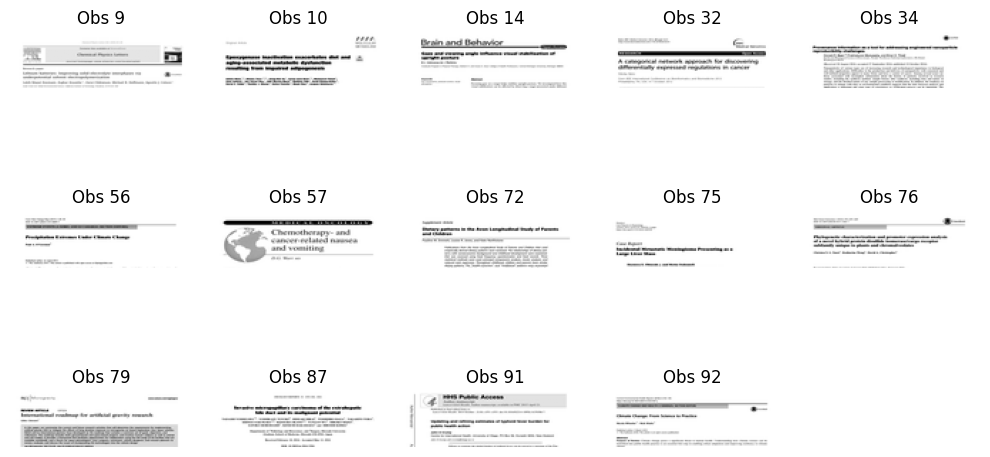

In [18]:
# Anta att X_test är flattenad (shape: n_samples, 128*128)
# Om du har X_test_scaled, använd X_test istället för att visa originalbilder
# Hämta index för förstasidor i testdatan
firstpage_idx = np.where(y_test == 1)[0]

# Återskapa 2D-bilder från X_test (top40 flattenad)
# X_test shape: (n_samples, 40*128)
# Varje bild: (40, 128)
n_cols = 5
n_rows = int(np.ceil(len(firstpage_idx) / n_cols))

plt.figure(figsize=(n_cols*2, n_rows*2))
for i, idx in enumerate(firstpage_idx):
    plt.subplot(n_rows, n_cols, i+1)
    img = X_test[idx].reshape(40, 128)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Obs {idx}')
plt.tight_layout()
plt.show()

In [30]:
voting = VotingClassifier(
    estimators=[
        ('rfc', rfc),
        ('knc', knc)
    ],
    voting='soft'
)

voting.fit(X_trained_scaled, y_train)
y_pred_voting = voting.predict(X_test_scaled)

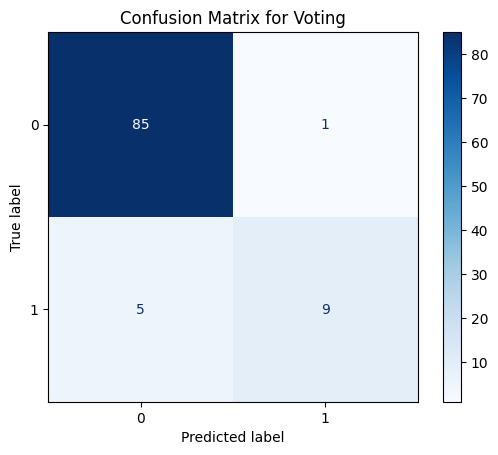

In [31]:
voting_y_proba = voting.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3
voting_y_pred = (voting_y_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, voting_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Voting")
plt.show()